# Non Linear Controller

In [13]:
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

import numpy as np 
import math
from math import sin, cos
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

from drone import Drone2D

import trajectories
import simulate
import plotting

pylab.rcParams['figure.figsize'] = 10, 10

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### TODO - Implement 2D controller with NON-LINEAR control equations.

The non-linear equations of motion are shown below.

$$\begin{align}
\ddot{z} &= g - \frac{u_1}{m}\cos\phi
\\
\\
\ddot{y} &= \frac{u_1}{m}\sin\phi
\\
\\
\ddot{\phi} &= \frac{u_2}{I_x}
\end{align}$$

These equations can be solved for $u_1$, $\phi_{\text{command}}$, and $u_2$.

$$\begin{align}
u_1 &= \frac{m(g - \bar{u_1})}{\cos\phi}
\\
\\
\phi_{\text{command}} &= \sin^{-1}\left(\frac{m\ddot{y}_{\text{target}}}{u_1}\right)
\\
\\
u_2 &= I_x \bar{u}_2 
\end{align}$$

The first equation will be useful when implementing `altitude_controller`, the second when implementing `lateral_controller`, and the third when implementing `altitude_controller`.

Note that $\ddot{y}_{\text{target}}$ is like $\bar{u}_1$ or $\bar{u}_2$. It comes from PD control on the controller's inputs.

In [14]:
class NonLinearCascadingController:
    
    def __init__(self,
                 m,
                 I_x,
                 z_k_p=1.0,   
                 z_k_d=1.0,   
                 y_k_p=1.0,
                 y_k_d=1.0,
                 phi_k_p=1.0,
                 phi_k_d=1.0):
        
        self.z_k_p = z_k_p
        self.z_k_d = z_k_d   
        self.y_k_p = y_k_p
        self.y_k_d = y_k_d
        self.phi_k_p = phi_k_p
        self.phi_k_d = phi_k_d
        
        self.g = 9.81
        self.I_x = I_x
        self.m = m
                    
    def altitude_controller(self, 
                    z_target, 
                    z_actual, 
                    z_dot_target, 
                    z_dot_actual,
                    z_dot_dot_target,
                    phi_actual):

        # TODO (recommended to do AFTER attitude)
        #   Implement feedforward PD control to calculate
        #   u_1_bar and then use the non-linear math from above
        #   to transform u_1_bar into u_1 and then return u_1
        err = z_target-z_actual
        err_dot = z_dot_target-z_dot_actual
        
        acc = z_dot_dot_target + err*self.z_k_p + err_dot*self.z_k_d
        
        
        u_1 = self.m*(self.g-acc)/cos(phi_actual)
        return u_1
    
    
    def lateral_controller(self, 
                        y_target,
                        y_actual, 
                        y_dot_target, 
                        y_dot_actual,
                        u_1,
                        y_dot_dot_ff=0.0,
                        ):
        
        # TODO (recommended to do AFTER attitude)
        #   Implement feedforward PD control to calculate
        #   y_dot_dot_target and then use the non-linear math from above
        #   to transform y_dot_dot_target into phi_commanded
        #   and then return phi_commanded
        err = y_target-y_actual
        err_dot = y_dot_target-y_dot_actual
        
        acc = y_dot_dot_ff + err*self.y_k_p + err_dot*self.y_k_d
        
        phi_commanded = math.asin((self.m*acc)/u_1)
        
        return phi_commanded 
    
    
    def attitude_controller(self, 
                        phi_target, 
                        phi_actual, 
                        phi_dot_actual,
                        phi_dot_target=0.0 
                        ):
        # TODO (recommended to do FIRST)
        #   Implement PD control to calculate u_2_bar
        #   and then use the linear math from above to
        #   transform u_2_bar into u_2 and then return u_2
        
        err = phi_target-phi_actual
        err_dot = phi_dot_target-phi_dot_actual
        
        acc = err*self.phi_k_p+err_dot*self.phi_k_d
        
        u_2 = self.I_x * acc
        return u_2

The flight path we'll use to test our controller is a figure 8 described as follows:
$$
\begin{align}
z & = a_z \sin{\omega_z t} \\
y & = a_y \cos{\omega_y t}
\end{align}
$$

where $\omega_y = \omega_z / 2$. 

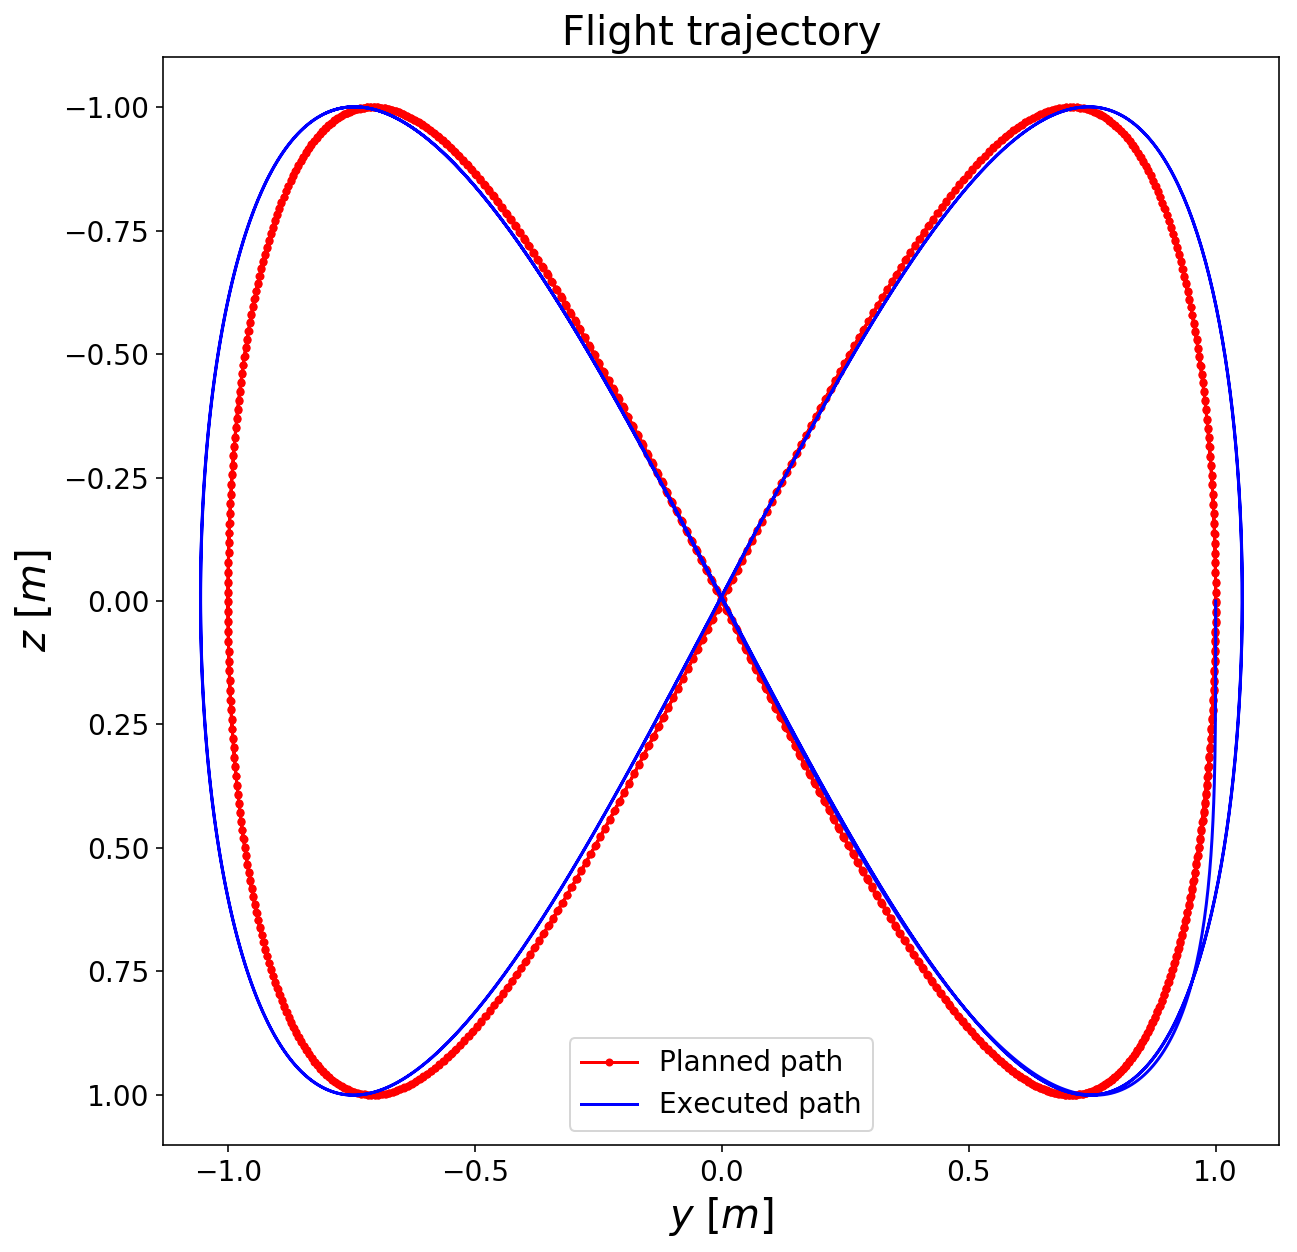

In [17]:
# TESTING CELL 
# 
# Note - this cell will only give nice output when your code
#  is working AND you've tuned your parameters correctly.
#  you might find it helpful to come up with a strategy
#  for first testing the inner loop controller and THEN 
#  testing the outer loop.
#
# Run this cell when you think your controller is ready!
#
# You'll have to tune the controller gains to get good results.

#### CONTROLLER GAINS (TUNE THESE) ######

z_k_p   = 10.0  
z_k_d   = 3.0   
y_k_p   = 0.05
y_k_d   = 2.0
phi_k_p = 20.0
phi_k_d = 8.0

#########################################

drone = Drone2D()

# INSTANTIATE CONTROLLER
non_linear_controller = NonLinearCascadingController(
    drone.m,
    drone.I_x,
    z_k_p=z_k_p,   
    z_k_d=z_k_d,   
    y_k_p=y_k_p,
    y_k_d=y_k_d,
    phi_k_p=phi_k_p,
    phi_k_d=phi_k_d
)

# TRAJECTORY PARAMETERS (you don't need to change these)
total_time = 30.0  
omega_z = 1.0       # angular frequency of figure 8

# GENERATE FIGURE 8
z_traj, y_traj, t = trajectories.figure_8(omega_z, total_time, dt=0.02)
z_path, z_dot_path, z_dot_dot_path = z_traj
y_path, y_dot_path, y_dot_dot_path = y_traj

# SIMULATE MOTION
linear_history     = simulate.zy_flight(z_traj, 
                                        y_traj,
                                        t, 
                                        non_linear_controller,
                                        inner_loop_speed_up=10)
# PLOT RESULTS
pylab.rcParams['figure.figsize'] = 10,10
plotting.plot_zy_flight_path(z_path, y_path, linear_history)

[Solution](/notebooks/Non-Linear%20Controller%20Solution.ipynb)